# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignment by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Part 4: Fine-tuning pretrained language models

Acknowledgement: This notebook is based on the code from https://mccormickml.com/2019/07/22/BERT-fine-tuning/. Credit to 
Chris McCormick and Nick Ryan.

## Background

Fine-tuning BERT on our task of interest takes some setup. Although these steps are done for you, please take a moment to look through them and make sure you understand their purpose.

Install the [HuggingFace Transformers](https://huggingface.co/docs/transformers/index) package that contains the pretrained BERT models.



In [1]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.1 MB/s eta 0:00:00


Set the random seeds for reproducibility.

In [2]:
import os
import random

import numpy as np
import torch

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

Run the following cells to download the verbal arithmetic dataset from the CSC413 webpage and load it into a `DataFrame`


In [3]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=b5ab8cb84f463c6c3bb3262100fc27c31c9dd5164f1b66273f63bcf2af7b1779
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [4]:
import wget
import os

print('Downloading verbal arithmetic dataset')

# The URL for the dataset zip file.
url = 'https://csc413-uoft.github.io/2021/assets/misc/'

# Download the file (if we haven't already)
if not os.path.exists('./PA03_data_20_train.csv'):
  wget.download(url + 'PA03_data_20_train.csv', './PA03_data_20_train.csv')
  print('Done downloading training data')
else:
  print('Already downloaded training data')

if not os.path.exists('./PA03_data_20_test.csv'):
  wget.download(url + 'PA03_data_20_test.csv', './PA03_data_20_test.csv')
  print('Done downloading test data')
else:
  print('Already downloaded test data')

Done downloading training data
Done downloading test data


In [5]:
import pandas as pd

df = pd.read_csv("./PA03_data_20_train.csv", header=0, names=["index", "input", "label"])

print("Number of data points: ", df.shape[0])
sampled = df.sample(10)
# Display 10 random rows from the data.
df.sample(10)

Number of data points:  640


,index,input,label
20,264,thirteen plus four,2
180,712,fifteen minus twelve,2
270,327,sixteen plus seven,2
221,58,two plus eighteen,2
542,646,twelve minus six,2
143,626,eleven minus six,2
247,759,seventeen minus nineteen,0
467,691,fourteen minus eleven,2
283,372,eighteen plus twelve,2
259,274,thirteen plus fourteen,2


### Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. For this we can use the `AutoTokenizer` from the `transformers` library.

As mentioned in the assignment handout, we will use [MathBERT](https://arxiv.org/abs/2106.07340), which uses the same architecture as BERT, but has been pretrained on text from pre-kindergarten, high-school, and college graduate level mathematical content.


In [6]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained('tbs17/MathBERT', do_lower_case=True)

In [7]:
inputs = df.input.values
labels = df.label.values
print("Train data size ", len(inputs))
print('* Original:  ', inputs[0])
# Print the sentence split into tokens.
print('* Tokenized: ', bert_tokenizer.tokenize(inputs[0]))
# Print the sentence mapped to token ids.
print('* Token IDs: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(inputs[0])))

Train data size  640
* Original:   five minus twelve
* Tokenized:  ['five', 'minus', 'twelve']
* Token IDs:  [2274, 15718, 4376]


### Formatting the inputs

In order to use BERT for fine-tuning, we need to format the inputs in a way that matches the inputs of the pretraining step. In short, we need to:

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".


#### Special Tokens

**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output.

On the output of the final transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Also, because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector.

#### Sentence Length & Attention Mask

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. 

The "Attention Mask" is simply an array of 0s and 1s indicating which tokens are padding and which aren't.

In our dataset, all sentences have three word tokens. However, we set the max length of sentence to 7 in this example to show what paddings will be in real world applications.

In [8]:
# Set the maximum sequence length.
MAX_LEN = 7

# Print BERTs special PAD token and its index in the vocabulary
print(f'Padding token: "{bert_tokenizer.pad_token}", ID: {bert_tokenizer.pad_token_id}')

Padding token: "[PAD]", ID: 0


Luckily, the `BertTokenizer` object from the transformers library makes it easy to preprocess our input text correctly


In [9]:
tokenized_inputs = bert_tokenizer(
    inputs.tolist(),          # Input text
    add_special_tokens=True,  # add '[CLS]' and '[SEP]'
    padding='max_length',     # pad to a length specified by the max_length
    max_length=MAX_LEN,       # truncate all sentences longer than max_length
    return_tensors='pt',      # return everything we need as PyTorch tensors
)

input_ids = tokenized_inputs['input_ids']
attention_masks = tokenized_inputs['attention_mask']

# Print sentence 0, now as a list of IDs.
print('Original: ', tokenized_inputs['input_ids'][0])
print('* Token IDs:', tokenized_inputs['attention_mask'][0])
print('* Tokenized:', bert_tokenizer.decode(tokenized_inputs['input_ids'][0]))
print('* Attention_mask', tokenized_inputs['attention_mask'][0])

Original:  tensor([  101,  2274, 15718,  4376,   102,     0,     0])
* Token IDs: tensor([1, 1, 1, 1, 1, 0, 0])
* Tokenized: [CLS] five minus twelve [SEP] [PAD] [PAD]
* Attention_mask tensor([1, 1, 1, 1, 1, 0, 0])


### Training & Validation Split

Let's divide up our data into a train set (70%) and a validation set (30%).

We'also create an iterator for our dataset using the torch `DataLoader` class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [10]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def train_valid_split(input_ids, attention_masks, labels, batch_size=32):
    # Use 70% for training and 30% for validation.
    train_inputs, validation_inputs,  train_masks, validation_masks, train_labels, validation_labels = train_test_split(
        input_ids, attention_masks, labels, random_state=SEED, test_size=0.3, stratify=labels
    )

    print('example train_input:    ', train_inputs[0])
    print('example attention_mask: ', train_masks[0])

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Create the DataLoader for our validation set.
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

    return train_dataloader, validation_dataloader

In [11]:
bert_train_dataloader, bert_validation_dataloader = train_valid_split(
    input_ids=input_ids,
    attention_masks=attention_masks,
    labels=labels,
    batch_size=32
)

example train_input:     tensor([  101,  2416, 15718,  7032,   102,     0,     0])
example attention_mask:  tensor([1, 1, 1, 1, 1, 0, 0])


## Questions

### Question 1: Add a classifier to BERT [1pts]

Here, we will add a simple classifier to the [BertModel](https://huggingface.co/docs/transformers/v4.16.2/en/model_doc/bert#transformers.BertModel) provided by the Transformers library.

Your tasks are:

1. In `__init__`, add a linear classifier that will map BERTs `[CLS]` token representation to the unnormalized output probabilities for each class (`logits`).
2. In `forward`, pass BERTs `[CLS]` token representation to this new classifier to produce the `logits`.

In total, you won't have to write more than three new lines of code. See the comments in the code for help!

In [12]:
from transformers import BertModel
import torch.nn as nn

class BertForSentenceClassification(BertModel):
    def __init__(self, config):
        super().__init__(config)
        
        ##### START YOUR CODE HERE #####
        # Add a linear classifier that map BERTs [CLS] token representation to the unnormalized
        # output probabilities for each class (logits).
        # Notes: 
        #  * See the documentation for torch.nn.Linear
        #  * You do not need to add a softmax, as this is included in the loss function
        #  * The size of BERTs token representation can be accessed at config.hidden_size
        #  * The number of output classes can be accessed at config.num_labels
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)
        ##### END YOUR CODE HERE #####
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, labels=None, **kwargs):
        outputs = super().forward(**kwargs)
        ##### START YOUR CODE HERE #####
        # Pass BERTs [CLS] token representation to this new classifier to produce the logits.
        # Notes:
        #  * The [CLS] token representation can be accessed at outputs.pooler_output
        cls_token_repr = outputs.pooler_output
        logits = self.classifier(cls_token_repr)
        ##### END YOUR CODE HERE #####
        if labels is not None:
            outputs = (logits, self.loss(logits, labels))
        else:
            outputs = (logits,)
        return outputs

### Question 2: Fine-tune BERT [0pts]

In this section, we will instantiate our pretrained BERT model + the new classifier, and train both on our verbal arithmetic dataset for a few epochs.

As mentioned in the assignment handout, we will use [MathBERT](https://arxiv.org/abs/2106.07340), which uses the same architecture as BERT, but has been pretrained on text from pre-kindergarten, high-school, and college graduate level mathematical content.


> Although the code is written for you, please read it first to understand what it is doing. Additionally, running this code and making sure the model can be fine-tuned helps you check your implementation from Question 1. __Note__: This may print a warning: _"Some weights of the model checkpoint at..."_ which you can ignore.

In [13]:
mathbert = BertForSentenceClassification.from_pretrained(
    "tbs17/MathBERT",  # the name of the pretrained model
    num_labels=3,      # the number of classes in our downstream task 
)

Some weights of the model checkpoint at tbs17/MathBERT were not used when initializing BertForSentenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSentenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSentenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSentenceClassification were not initialized

The following cell prints information about the models parameters

In [14]:
# Model parameters visualization
params = list(mathbert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer Layer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer Layer ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias              

The next cell defines fairly standard train and evaluation loops in PyTorch

In [15]:
from torch.optim import AdamW
import time
import datetime
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed, 2))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def get_optimizer_and_scheduler(model, total_steps, lr=2e-5, weight_decay=0.01):
    # Apply weight decay to all parameters beside the biases or LayerNorm weights
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': weight_decay},
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        # Warmup learning rate for first 10% of training steps
        num_warmup_steps=int(0.10 * total_steps), 
        num_training_steps=total_steps,
    )
    return optimizer, scheduler

def train_model(model, epochs, train_dataloader, validation_dataloader):
    # Use GPU, if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Setup optimizer and LR scheduler 
    total_steps = len(train_dataloader) * epochs
    optimizer, scheduler = get_optimizer_and_scheduler(
        model, total_steps, lr=5e-5, weight_decay=0.01
    )

    loss_values = []
    eval_accs = []

    start = time.time()

    for epoch in range(0, epochs):
        t0 = time.time()

        total_loss = 0
        model.train()

        with tqdm(train_dataloader, unit="batch") as train_pbar:
            for batch in train_pbar:
                train_pbar.set_description(f"Training (epoch {epoch + 1})")
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # This will return the loss because we have provided the `labels`.
                outputs = model(
                    input_ids=b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels
                )
                
                # The call to `model` always returns a tuple, so we need to pull the 
                # loss value out of the tuple.
                _, loss = outputs

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                optimizer.step()

                # Update the learning rate.
                scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("  * Average training loss: {0:.2f}".format(avg_train_loss))
        print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
            
        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                outputs = model(
                    input_ids=b_input_ids, 
                    attention_mask=b_input_mask
                )
            
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            # Track the number of batches
            nb_eval_steps += 1

        avg_eval_acc = eval_accuracy/nb_eval_steps
        print("  * Accuracy: {0:.2f}".format(avg_eval_acc))
        print("  * Validation took: {:}".format(format_time(time.time() - t0)))
        eval_accs.append(avg_eval_acc)
    print("Training complete in {}".format(format_time(time.time() - start)))
    return loss_values, eval_accs

Finally, run the following cell to fine-tune the model

In [16]:
# About 2-3 seconds per epoch using GPU
mathbert_loss_vals, mathbert_eval_accs = train_model(
    model=mathbert,
    epochs=3,
    train_dataloader=bert_train_dataloader,
    validation_dataloader=bert_validation_dataloader
)

Training (epoch 1): 100%|██████████| 14/14 [00:04<00:00,  3.05batch/s]


  * Average training loss: 0.62
  * Training epoch took: 0:00:04
Running Validation...
  * Accuracy: 0.76
  * Validation took: 0:00:00


Training (epoch 2): 100%|██████████| 14/14 [00:01<00:00, 10.98batch/s]


  * Average training loss: 0.40
  * Training epoch took: 0:00:01
Running Validation...
  * Accuracy: 0.88
  * Validation took: 0:00:00


Training (epoch 3): 100%|██████████| 14/14 [00:01<00:00, 11.06batch/s]


  * Average training loss: 0.27
  * Training epoch took: 0:00:01
Running Validation...
  * Accuracy: 0.89
  * Validation took: 0:00:00
Training complete in 0:00:07


Once the model is trained, we can plot some performance metrics

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_and_acc(loss_vals, eval_accs):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(loss_vals, 'b-o', label = 'training loss')
    ax2 = ax1.twinx()
    ax2.plot(eval_accs, 'y-o', label = 'validation accuracy')
    ax2.set_title("Training loss and validation accuracy")
    ax2.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='b')
    ax2.set_ylabel("Accuracy", color='y')
    ax1.tick_params(axis='y', rotation=0, labelcolor='b' )
    ax2.tick_params(axis='y', rotation=0, labelcolor='y' )
    plt.show()

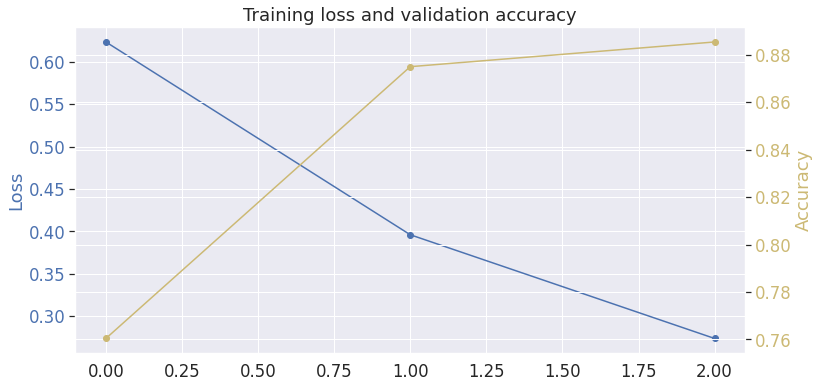

In [18]:
plot_loss_and_acc(mathbert_loss_vals, mathbert_eval_accs)

### Question 3: Freezing the pretrained weights [0.5pts]

Now, lets try training the model again, except this time we will _not_ fine-tune BERTs weights (we sometimes say these weights are "frozen"). To do this, we will only compute gradients for the classifiers parameters.

> We can do this in pytorch by setting the `requires_grad` attribute to `False` for all parameters beside the classifiers.

Run the following cells to instantiate the model and train only the classifier. Then answer the follow-up questions in the assignment handout.

> __Note__: This may print a warning: _"Some weights of the model checkpoint at..."_ which you can ignore.

In [19]:
mathbert_frozen = BertForSentenceClassification.from_pretrained(
    "tbs17/MathBERT",  # the name of the pretrained model
    num_labels=3,      # the number of classes in our downstream task
)

Some weights of the model checkpoint at tbs17/MathBERT were not used when initializing BertForSentenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSentenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSentenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSentenceClassification were not initialized

In [20]:
for name, param in mathbert_frozen.named_parameters():
	# Only compute gradients for parameters of our
	# newly added classifier. BERT will not be trained.
	if 'classifier' not in name:
		param.requires_grad = False

In [21]:
# About 1 second per epoch on GPU
mathbert_frozen_loss_vals, mathbert_frozen_eval_accs = train_model(
    model=mathbert_frozen,
    epochs=3, 
    train_dataloader=bert_train_dataloader,
    validation_dataloader=bert_validation_dataloader
)

Training (epoch 1): 100%|██████████| 14/14 [00:00<00:00, 37.70batch/s]


  * Average training loss: 1.36
  * Training epoch took: 0:00:00
Running Validation...
  * Accuracy: 0.04
  * Validation took: 0:00:00


Training (epoch 2): 100%|██████████| 14/14 [00:00<00:00, 47.70batch/s]


  * Average training loss: 1.22
  * Training epoch took: 0:00:00
Running Validation...
  * Accuracy: 0.06
  * Validation took: 0:00:00


Training (epoch 3): 100%|██████████| 14/14 [00:00<00:00, 51.17batch/s]


  * Average training loss: 1.15
  * Training epoch took: 0:00:00
Running Validation...
  * Accuracy: 0.10
  * Validation took: 0:00:00
Training complete in 0:00:01


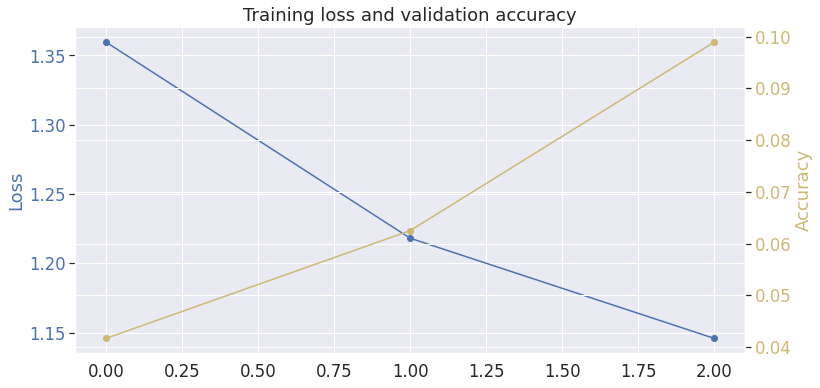

In [22]:
plot_loss_and_acc(mathbert_frozen_loss_vals, mathbert_frozen_eval_accs)

### Question 4: Effect of pretraining data [0.5pts]

Now, let's try fine-tuning the model again, except this time we will use [BERTweets](https://arxiv.org/abs/2005.10200) pretrained weights. BERTweets uses the same architecture as BERT (and MathBERT), but has been pretrained on 100s of millions of _tweets_.

Run the following cells to instantiate our model with BERTweets pretrained weights and fine-tune it. Then answer the follow-up questions in the assignment handout.

> __Note__: This may print a warning: _"You are using a model of type..."_ which you can ignore.

In [23]:
bertweet = BertForSentenceClassification.from_pretrained(
    "vinai/bertweet-base",  # the name of the pretrained model
    num_labels=3,           # the number of classes in our downstream task
)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertForSentenceClassification: ['roberta.encoder.layer.4.attention.self.query.bias', 'roberta.encoder.layer.10.intermediate.dense.weight', 'roberta.encoder.layer.7.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'lm_head.layer_norm.weight', 'roberta.encoder.layer.9.attention.output.dense.weight', 'roberta.encoder.layer.4.attention.self.key.weight', 'roberta.encoder.layer.2.attention.output.dense.weight', 'roberta.encoder.layer.6.attention.output.LayerNorm.bias', 'roberta.encoder.layer.11.output.dense.weight', 'roberta.encoder.layer.3.attention.self.key.bias', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.11.intermediate.dense.bias', 'roberta.encoder.layer.1.intermediate.dense.weight', 'roberta.encoder.layer.3.output.LayerNorm.bias', 'roberta.encod

BERTweets has its own tokenizer, so we have to repeat the data loading process

In [24]:
from transformers import AutoTokenizer

bertweet_tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', do_lower_case=True)

tokenized_inputs = bertweet_tokenizer(
    inputs.tolist(),
    add_special_tokens=True,
    padding='max_length',
    max_length=MAX_LEN,
    return_tensors='pt',
)

bert_train_dataloader, bert_validation_dataloader = train_valid_split(
    input_ids=tokenized_inputs['input_ids'],
    attention_masks=tokenized_inputs['attention_mask'],
    labels=labels,
    batch_size=32
)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


example train_input:     tensor([    0,  2401, 12309, 27495,     2,     1,     1])
example attention_mask:  tensor([1, 1, 1, 1, 1, 0, 0])


In [25]:
# About 2-3 seconds per epoch on GPU
bertweet_loss_vals, bertweet__eval_accs = train_model(
    model=bertweet,
    epochs=3, 
    train_dataloader=bert_train_dataloader,
    validation_dataloader=bert_validation_dataloader
)

Training (epoch 1): 100%|██████████| 14/14 [00:01<00:00,  9.64batch/s]


  * Average training loss: 0.62
  * Training epoch took: 0:00:01
Running Validation...
  * Accuracy: 0.76
  * Validation took: 0:00:00


Training (epoch 2): 100%|██████████| 14/14 [00:01<00:00,  9.96batch/s]


  * Average training loss: 0.53
  * Training epoch took: 0:00:01
Running Validation...
  * Accuracy: 0.77
  * Validation took: 0:00:00


Training (epoch 3): 100%|██████████| 14/14 [00:01<00:00,  9.91batch/s]


  * Average training loss: 0.44
  * Training epoch took: 0:00:01
Running Validation...
  * Accuracy: 0.76
  * Validation took: 0:00:00
Training complete in 0:00:04


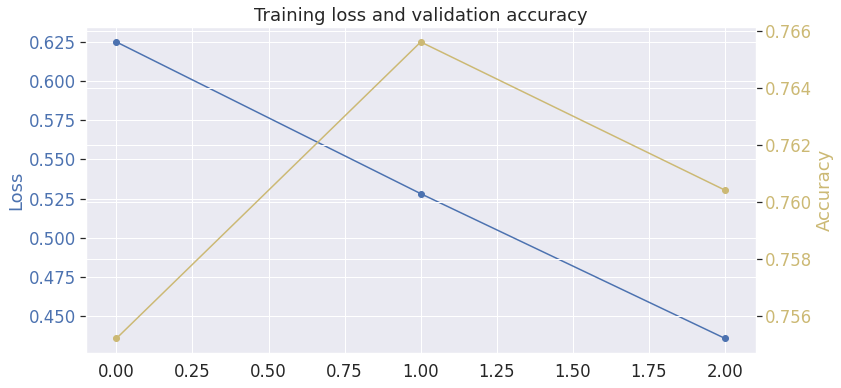

In [26]:
plot_loss_and_acc(bertweet_loss_vals, bertweet__eval_accs)

### Question 5: Inspect models predictions [0pts]

In the following cell, we have provided a function that allows you to inspect the models predictions. Given an input, e.g. `"three minus two minus two"`, it will return a trained models prediction i.e. `"negative"`, `"zero"`, or `"positive"`.

Compare the performance of `mathbert`, `mathbert_frozen` and `bertweet`. Try a few unseen examples of arithmetic questions using all models. Can you find examples where one model clearly outperforms the others? Can you find examples where all models perform poorly?

In [27]:
def what_is(input, model, tokenizer):
    # Use GPU, if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Get map of human readable outputs
    index_to_sentiment_map = {0: "negative", 1: "zero", 2: "positive"}
    
    tokenized_inputs = tokenizer(
        input,                    # Input text
        add_special_tokens=True,  # add '[CLS]' and '[SEP]'
        padding='max_length',     # pad to a length specified by the max_length
        max_length=MAX_LEN,       # truncate all sentences longer than max_length
        return_tensors='pt',      # return everything we need as PyTorch tensors
    )

    input_ids = tokenized_inputs['input_ids'].to(device)
    attention_masks = tokenized_inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_masks)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        print(index_to_sentiment_map[np.argmax(logits, axis=1)[0]])

In [28]:
what_is("three minus five", model=mathbert, tokenizer=bert_tokenizer)

negative


In [29]:
what_is("three minus five", model=mathbert_frozen, tokenizer=bert_tokenizer)

zero


In [30]:
what_is("three minus five", model=bertweet, tokenizer=bert_tokenizer)

positive
